In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Now we need to access the files downloaded, copy the path where you saved the files downloaded from the github repo and replace the path below
%cd /content/drive/MyDrive/path/to/files/cloned/from/repo/and/now/in/your/GoogleDrive/


In [ ]:
!git clone https://github.com/paulvangentcom/heartrate_analysis_python.git
!pip install neurokit2
!pip install pandas==1.1.5
#Change the path below to the place to the directory that has the heartrate_analysis_python directory
%cd /content/drive/MyDrive/YOURPATH/heartrate_analysis_python

!python setup.py install

In [ ]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib
import neurokit2 as nk
import matplotlib.pyplot as plt

import os
import heartpy as hp
import random
#from pylsl import StreamInfo,  StreamOutlet, resolve_stream, StreamInlet

from sklearn.cross_decomposition import CCA
from scipy import signal

from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq, ifft

import pickle

plt.rcParams['figure.figsize'] = [20, 15]

## **Offline PPG data visualization and processing**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/PPG-RAW-2022-01-06_19-22-11.txt',header=4 ,sep=r'\s*,\s*',engine='python')
data.columns = ["Sample Index",	"EMG Channel 0",	"EMG Channel 1",	"EMG Channel 2",	"EMG Channel 3",	"EOG Channel 0",	"EOG Channel 1",	"EEG Channel 0",	"EEG Channel 1",	"EEG Channel 2",	"EEG Channel 3",	"EEG Channel 4",	"EEG Channel 5",	"EEG Channel 6",	"EEG Channel 7",	"EEG Channel 8",	"EEG Channel 9",	"PPG Channel 0",	"PPG Channel 1",	"EDA_Channel_0",	"Other",	"Raw PC Timestamp",	"Raw Device Timestamp",	"Other.1",	"Timestamp",	"Marker",	"Timestamp (Formatted)"]
data

In [ ]:
#Collect and process PPG
sample_rate = 250

ppg_signal =data["PPG Channel 1"]
ppg_signal = nk.as_vector(ppg_signal)  # Extract the only column as a vector
ppg_signal 
ppg_signal = ppg_signal - np.mean(ppg_signal)
hp_ppg = data["PPG Channel 1"] 

In [ ]:
hp_ppg = nk.as_vector(hp_ppg)


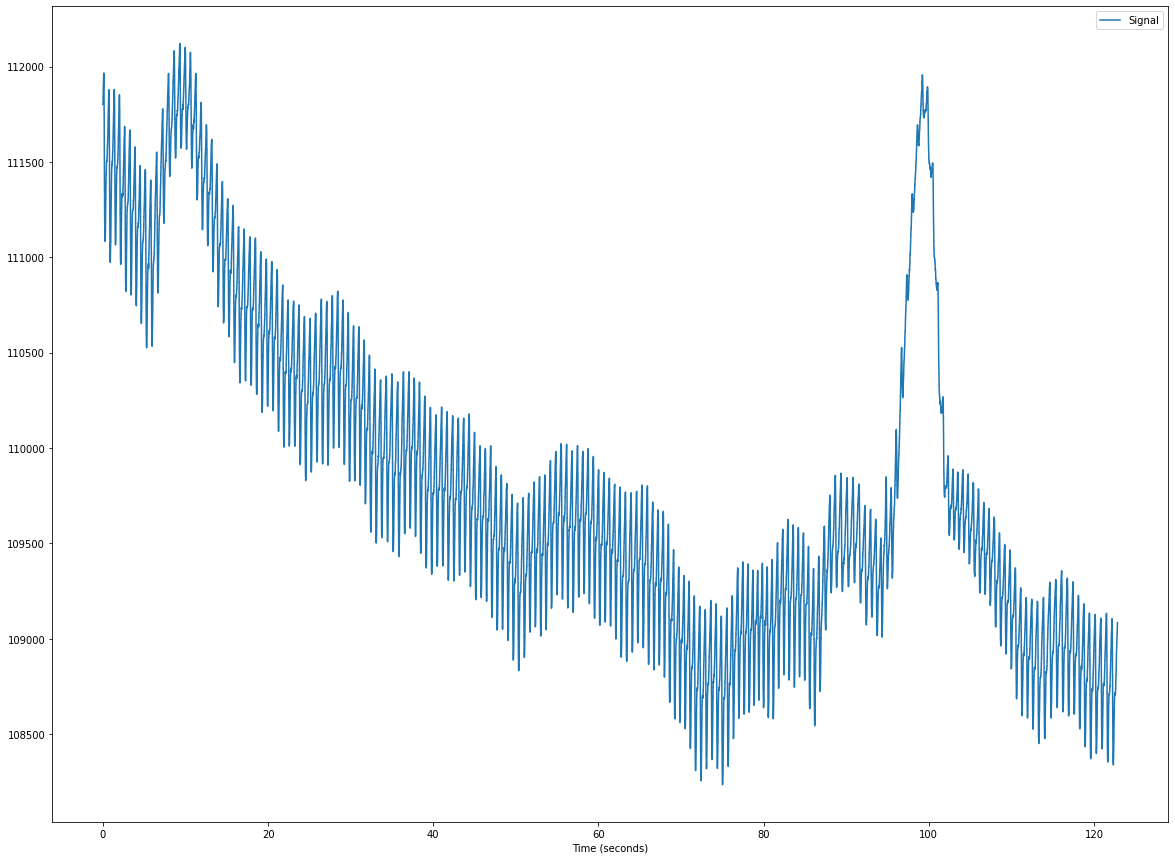

In [ ]:
nk.signal_plot(hp_ppg[10:], standardize=False,sampling_rate=250)

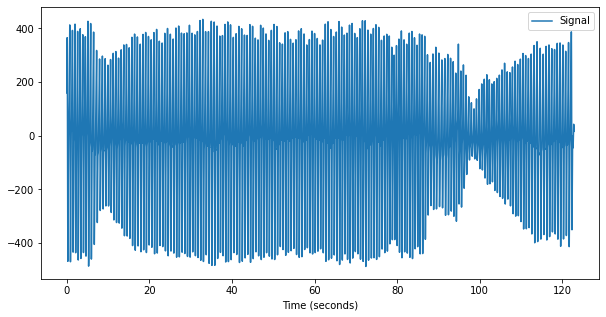

In [ ]:
filtered  = hp.filter_signal(hp_ppg[10:],cutoff=[0.8,8.5],order=2, filtertype='bandpass',sample_rate=250)
nk.signal_plot(filtered, standardize=False,sampling_rate=250)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back


Finished in 0.045757 sec
bpm: 91.879075
ibi: 653.032258
sdnn: 30.422986
sdsd: 11.178107
rmssd: 18.349166
pnn20: 0.232432
pnn50: 0.005405
hr_mad: 18.000000
sd1: 12.974378
sd2: 41.106973
s: 1675.528930
sd1/sd2: 0.315625
breathingrate: 0.133333
sd1: 20.699445
sd2: 70.189299
s: 4564.355626
sd1/sd2: 0.294909


<Figure size 864x432 with 0 Axes>

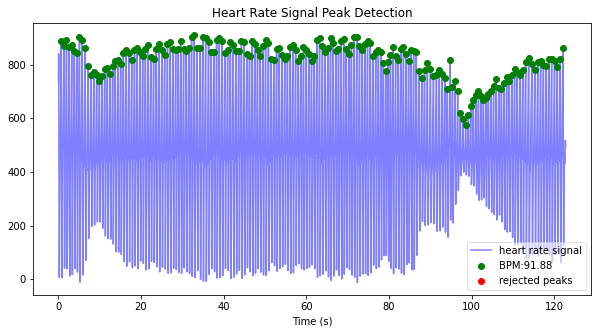

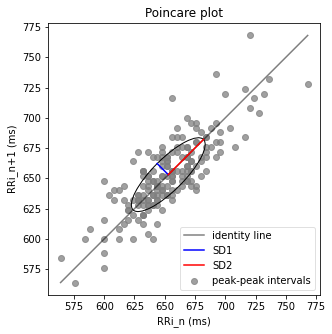

In [ ]:
enhanced = hp.enhance_peaks(filtered[10:], iterations=0)

working_data, measures = hp.process(enhanced, 250, report_time=True)
plt.figure(figsize=(12,6))
hp.plotter(working_data, measures)

for key in measures.keys():
    print('%s: %f' %(key, measures[key]))
    
#and plot poincare
image_format = 'eps' # e.g .png, .svg, etc
poincare_measures = ['sd1', 'sd2', 's', 'sd1/sd2']

fig = hp.plot_poincare(working_data, measures,show=False)
for measure in poincare_measures:
    print('%s: %f' %(measure, m[measure]))

fig.savefig('/content/drive/MyDrive/YOURPATH/SharedPubliclyFigures/galea_ppg.eps', format=image_format, dpi=1200)


In [ ]:
print('breathing rate is: %s Hz' %measures['breathingrate'])

breathing rate is: 0.13333333333333333 Hz


In [ ]:
measures

{'bpm': 91.87907528156491,
 'breathingrate': 0.13333333333333333,
 'hr_mad': 18.0,
 'ibi': 653.0322580645161,
 'pnn20': 0.23243243243243245,
 'pnn50': 0.005405405405405406,
 'rmssd': 18.34916597265096,
 's': 1675.528930235567,
 'sd1': 12.974378302260497,
 'sd1/sd2': 0.315624752821112,
 'sd2': 41.10697334823432,
 'sdnn': 30.422986362325116,
 'sdsd': 11.178106536503268}

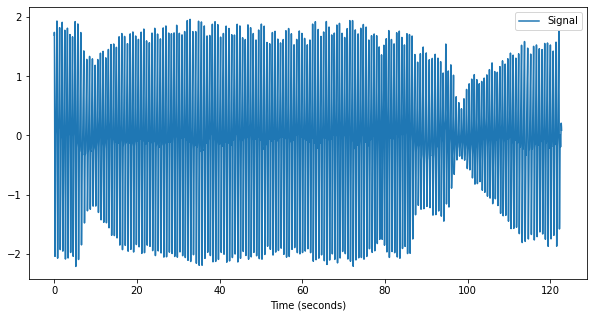

In [ ]:
ppg_signal = nk.signal_detrend(enhanced[10:], order=10)
nk.signal_plot(ppg_signal, standardize=True,sampling_rate=250)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


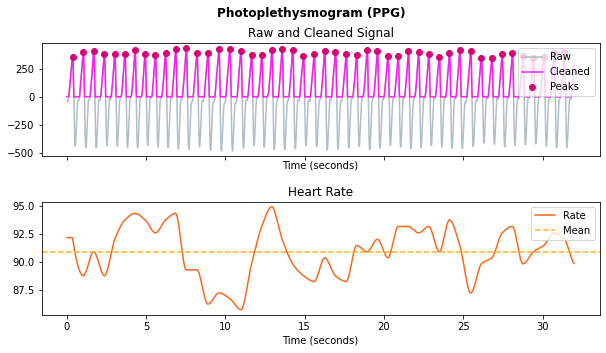

In [ ]:
signals2, info2 = nk.ppg_process(ppg_signal[6330:], sampling_rate=250)
# nk.signal_plot(signals2.PPG_Clean, sampling_rate=250)



plt.rcParams['figure.figsize'] = [10, 5]
path = '/content/drive/MyDrive/YOURPATH/SharedPublicly/Figures/'
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'galea_ppg2.eps'
fig = nk.ppg_plot(signals2[:8000], sampling_rate=250) 
fig.savefig(path+image_name, format=image_format, dpi=1200)